# Classification Problem with PyTorch

## Architecture of a classification model

| Hyperparameter               | Binary Classification                 | Multiclass Classification     |
|------------------------------|---------------------------------------|-------------------------------|
| **Input layer shape**        | Same as the number of features        | Same as binary classification |
| **Hidden layer(s)**          | Problem specific (minimum 1)          | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape**       | 1 (one class or the other)            | 1 per class                   |
| **Output activation**        | Sigmoid                               | Softmax                       |
| **Loss function**            | Binary Cross Entropy                  | Categorical Cross Entropy     |
| **Optimizer**                | Adam, SGD, etc.                       | Same as binary classification |

We can see them in this code snippet:

In [110]:
# # DO NOT RUN THIS CELL
#
# model = nn.Sequential(
#         nn.Linear(in_features=3, out_features=100), # in_features = input layer shape
#         nn.Linear(in_features=100, out_features=100), # hidden layer, with 100 neurons per hidden layer
#         nn.ReLU(), # hidden layer activation
#         nn.Linear(in_features=100, out_features=3) # output layer shape, 3 classes)
#
# loss_fn = nn.BCEWithLogitsLoss() # loss function
# optimizer = torch.optim.SGD(params=model.parameters(),
#                             lr=0.001) # optimizer

# Binary classification

### 1. Get the data ready for the model

#### Get the data

In [111]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [112]:
len(X), len(y) # check the number of samples

(1000, 1000)

#### Explore the data

In [113]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [114]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [115]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

Because the data label is 0 or 1, this is a binary classification problem.

#### Visualize the data

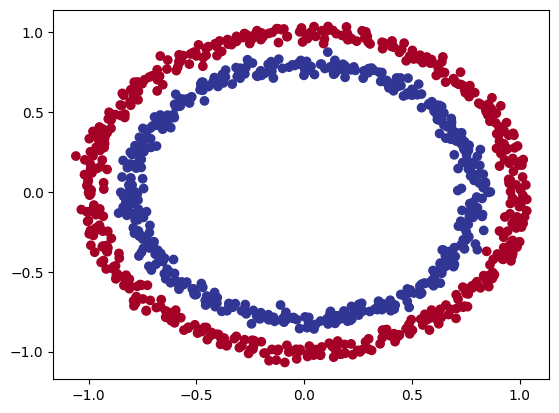

In [116]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

#### Check the input and output shapes

One of the most common errors in deep learning is shape errors.

Let's check the shape of our data:

In [117]:
X.shape, y.shape

((1000, 2), (1000,))

In [118]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This means that the second dimension of the input data (X) has two features, whereas the output data (y) has only one feature.

We have two inputs for one output.

#### Turn the data into tensors

In [119]:
import torch
torch.__version__ # check pytorch version

'2.6.0+cu126'

In [120]:
type(X), X.dtype, y.dtype # check the data types of X and y

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [121]:
# Turn the data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [122]:
type(X), X.dtype, y.dtype # check the data types of X and y again

(torch.Tensor, torch.float32, torch.float32)

In [123]:
# View the first five samples of X and y
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

#### Create a train/test split

In [124]:
from sklearn.model_selection import train_test_split

# Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

If we want to check what the result of the train/test split is, we can check the shape of the data: since `test_size=0.2`, we should have 80% of the data in the training set and 20% in the test set. In this case, a split of 800 training samples and 200 test samples.

In [125]:
# Check the shape of the train/test split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### 2. Build a model

In [126]:
from torch import nn
import numpy as np

In [127]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The objective is that given $X$ features (the data inputs), the model will predict $y$ labels (the data outputs).

Following this steps:

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers capable of handling the shape of the data
3. Define a `forward()` method to outline the forward pass of the model
4. Instantiate the model and send it to the target device (GPU or CPU)

In [128]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 linear layers capable of handling the shape of the data
        # Create a first linear layer
        # The first layer is the input layer, takes in 2 features and upscales it to 8 features
        self.layer_1 = nn.Linear(in_features=2, # X_train is 2D, so the input layer shape is 2
                                 out_features=8) # this number is arbitrary and usually is a multiple of 8
        # Create a second linear layer
        # The second layer is the output layer, takes in 8 features from the previous layer and downscales it to 1 feature
        # Same shape as y
        self.layer_2 = nn.Linear(in_features=8, # has to match the out_features of the previous layer to avoid shape errors
                                 out_features=1)
    # 3. Define a forward method to outline the forward pass of the model
    # It takes in the input data and passes it through the layers previously defined
    # x -> layer_1 -> layer_2 -> output
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
# 4. Instantiate the model and send it to the target device (GPU or CPU)
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

Let's now use `nn.Sequential()`: it performs a forward pass computation through all the layers in the model sequentially (in the order they are defined).

This is a more compact way of defining the model, but it is less flexible than subclassing `nn.Module`.

In [129]:
model_ = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

In [130]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

For now, we'll use the sequential model:

In [131]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.2730], device='cuda:0'))])

And make some predictions with it:

In [132]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967],
        [-0.0059],
        [-0.4633],
        [-0.3526],
        [ 0.1179],
        [-0.4903]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [133]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 3. Create a loss function and optimizer

For a binary classification problem, we can use the binary cross entropy loss function (`torch.nn.BCEWithLogits()` or `torch.nn.BCELoss`).

In this specific example, let's use `BCEWithLogitsLoss()`.

In [134]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits

For the optimizer, we can use `torch.optim.SGD()`:

In [135]:
# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1) # learning rate

Let's define a function to evaluate the model performance:

In [136]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Right now, the output of the model is a tensor of *logits*: logits are the raw, unnormalized scores output by the last layer of a neural network. You can read more on logits [here](https://wandb.ai/amanarora/Written-Reports/reports/Understanding-Logits-Sigmoid-Softmax-and-Cross-Entropy-Loss-in-Deep-Learning--Vmlldzo0NDMzNTU3).

To convert logits to prediction probabilities, they need to be passed through an activation function (depending on the type of classification problem).

After that, the probabilities can be converted to prediction labels.

In [137]:
# View the first 5 output logits of the forward pass on the test data
model_0.eval() # put the model in evaluation mode
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5] # get the first 5 logits
print(y_logits)

tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967]], device='cuda:0')


If we check the first 5 values from `y_test`, we can see that they are 0 or 1:

In [138]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

To convert logits to prediction probabilities, we can use the sigmoid activation function (since it's a binary classification problem) and then use `torch.round()` to convert the probabilities to prediction labels.

In [139]:
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]], device='cuda:0')


In [140]:
print(torch.round(y_pred_probs)) # convert probabilities to prediction labels

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')


But we need to set the decision boundary: if the probability is greater than 0.5, we can say that the model predicts class 1, otherwise it predicts class 0.

The value 0.5 is the default decision boundary for binary classification problems.

So if $p \geq 0.5$, we predict class 1, if $p < 0.5$, we predict class 0.

In [141]:
# Convert probabilities to prediction labels
y_pred = torch.round(y_pred_probs)

# Check the first 5 predictions and convert logits -> probabilities -> labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

# Remove the extra dimension
y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 4. Training loop

In [142]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70544, Accuracy: 48.25% | Test loss: 0.69447, Test acc: 53.00%
Epoch: 10 | Loss: 0.70088, Accuracy: 48.62% | Test loss: 0.69174, Test acc: 53.00%
Epoch: 20 | Loss: 0.69847, Accuracy: 48.38% | Test loss: 0.69083, Test acc: 54.50%
Epoch: 30 | Loss: 0.69698, Accuracy: 48.75% | Test loss: 0.69060, Test acc: 54.00%
Epoch: 40 | Loss: 0.69595, Accuracy: 49.00% | Test loss: 0.69066, Test acc: 54.00%
Epoch: 50 | Loss: 0.69521, Accuracy: 49.00% | Test loss: 0.69084, Test acc: 54.50%
Epoch: 60 | Loss: 0.69467, Accuracy: 49.00% | Test loss: 0.69109, Test acc: 53.00%
Epoch: 70 | Loss: 0.69425, Accuracy: 49.25% | Test loss: 0.69136, Test acc: 53.50%
Epoch: 80 | Loss: 0.69394, Accuracy: 49.25% | Test loss: 0.69165, Test acc: 54.00%
Epoch: 90 | Loss: 0.69371, Accuracy: 49.62% | Test loss: 0.69194, Test acc: 54.50%


From the results, it looks like the model isn't learning: the accuracy is stuck at around 50% and the loss is not decreasing.

To investigate this further, let's check the model's predictions on the test data and visualize them.

### Troubleshooting the model

In [143]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [144]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

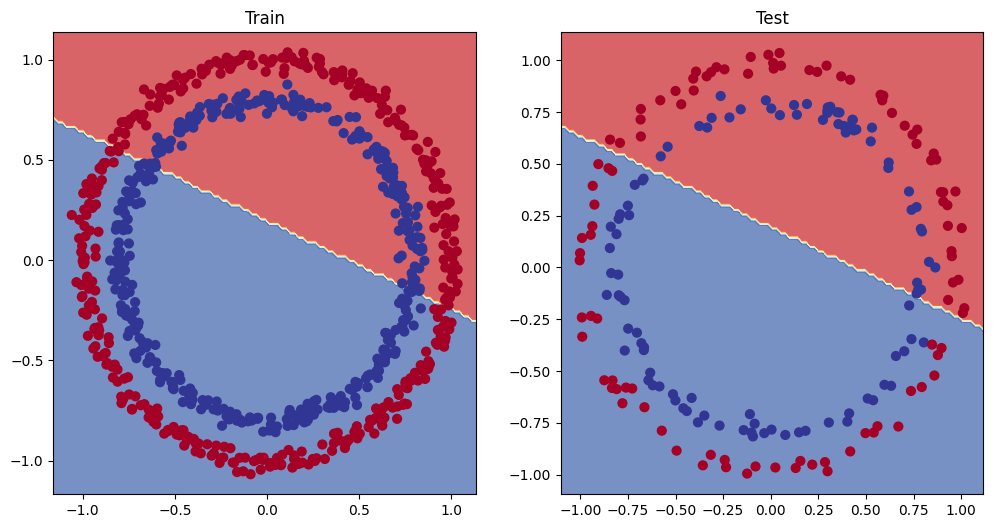

In [145]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

What the model is doing is trying to fit a straight line to the data, but that's not possible because the data is circular.

In this case, adding more layers, fitting the model for more epochs, and increasing the learning rate won't help.

Let's try that in practice:

In [146]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [147]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

This time, let's train the model for 1000 epochs:

In [148]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


As expected, the model still isn't performing well.

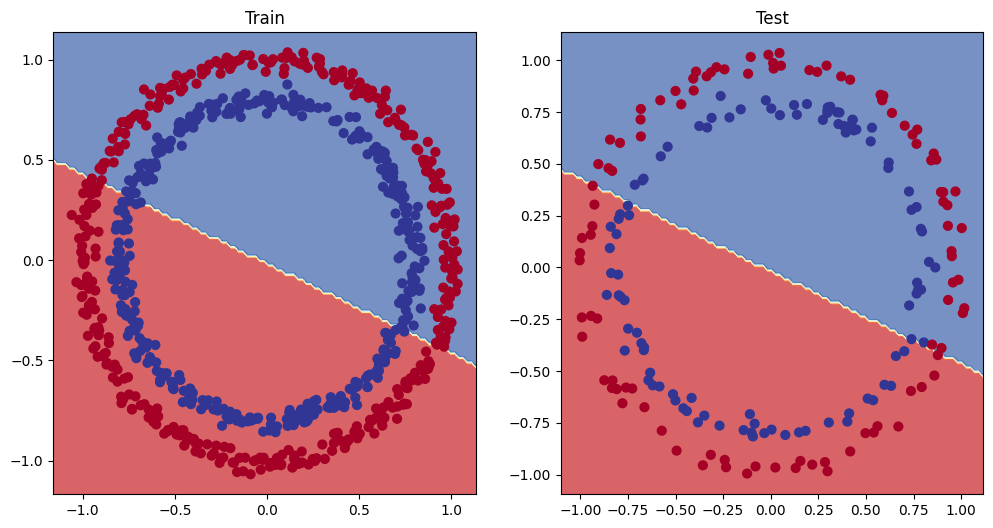

In [149]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The model is still trying to fit a straight line to the data.

One way to check if the model can learn is to break the problem into smaller parts: let's start by see if the model can fit a straight line to the data.

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything, and split it into training and test sets:

In [150]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [151]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


Visualize the data:

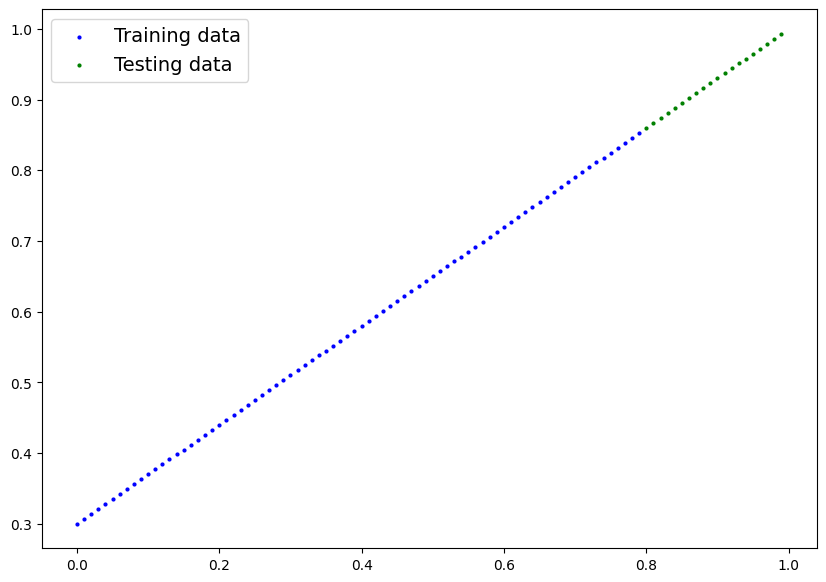

In [152]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

To keep it simple, let's use create a model with 3 linear layers, each with 10 neurons, but using `nn.Sequential()`.

Then, we'll use the same loss function and optimizer as before.

In [153]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [154]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

And now let's train the model:

In [155]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


It looks like the model is learning: the loss is decreasing.

Let's visualize the predictions:

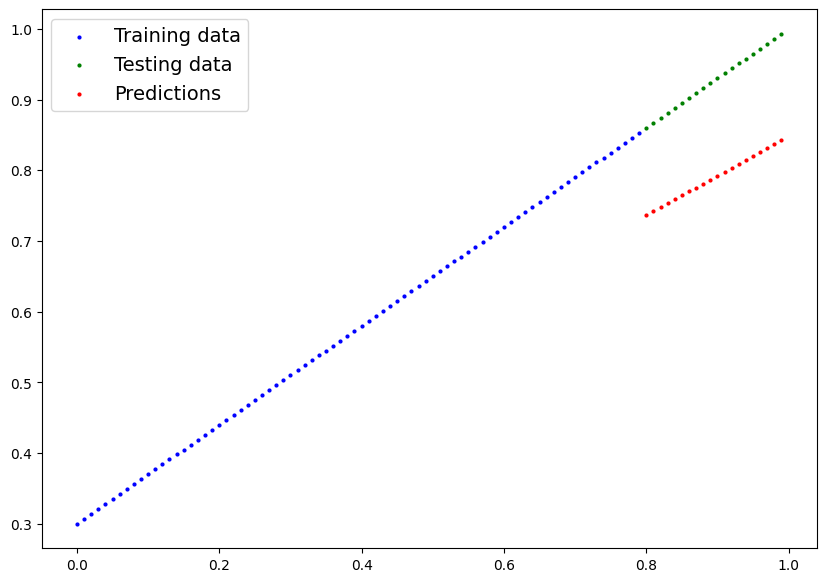

In [156]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

The model is able to learn the linear data.

Next, let's start fresh by getting the data again and building a model with a non-linear activation function.

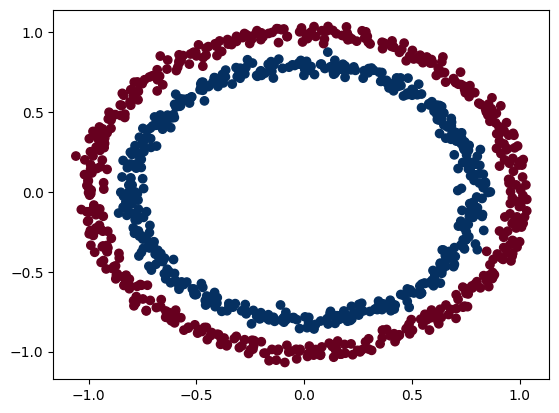

In [157]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

Let's convert the data to tensors and split it into training and test sets:

In [158]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

print(f"{X_train[:5]}, {y_train[:5]}")

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.])


One of the most common and best performing PyTorch activation functions is the ReLU (Rectified Linear Unit) activation function.


Let's add it to the neural network between the hidden layers in the forward pass:

In [159]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Next, let's define the loss function and optimizer:

In [160]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

And train the model with the new activation function:

In [161]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


This time, the model is learning: the loss is decreasing and the accuracy is increasing.

In [162]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

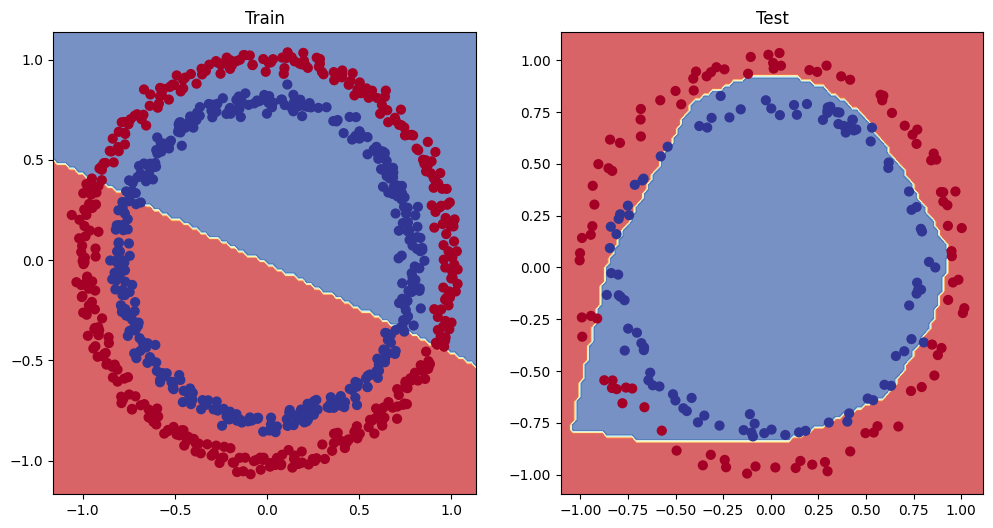

In [163]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Let's now increase the number of epochs to 10000 and see if the model can converge:

In [165]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV3().to(device)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [166]:
# Fit the model
torch.manual_seed(42)
epochs = 10000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)


# Stop fitting if the loss is less than 0.01
    if loss < 0.01:
        print(f"Stopping training early at epoch {epoch} with loss {loss:.5f}")
        break

    # Print out what's happening
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1500 | Loss: 0.12188, Accuracy: 99.62% | Test Loss: 0.16512, Test Accuracy: 99.00%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88% | Test Loss: 0.06583, Test Accuracy: 100.00%
Epoch: 2500 | Loss: 0.02383, Accuracy: 99.88% | Test Loss: 0.04363, Test Accuracy: 100.00%
Epoch: 3000 | Loss: 0.01672, Accuracy: 99.88% | Test Loss: 0.03363, Test Accuracy: 100.00%
Epoch: 3500 | Loss: 0.01288, Accuracy: 100.00% | Test Loss: 0.02841, Test Accuracy: 99.50%
Epoch: 4000 | Loss: 0.01048, Accuracy: 100.00% | Test Loss: 0.02451, Test Accuracy: 99.50%
Stopping training early at epoch 4130 with loss 0.01000


Let's visualize the predictions:

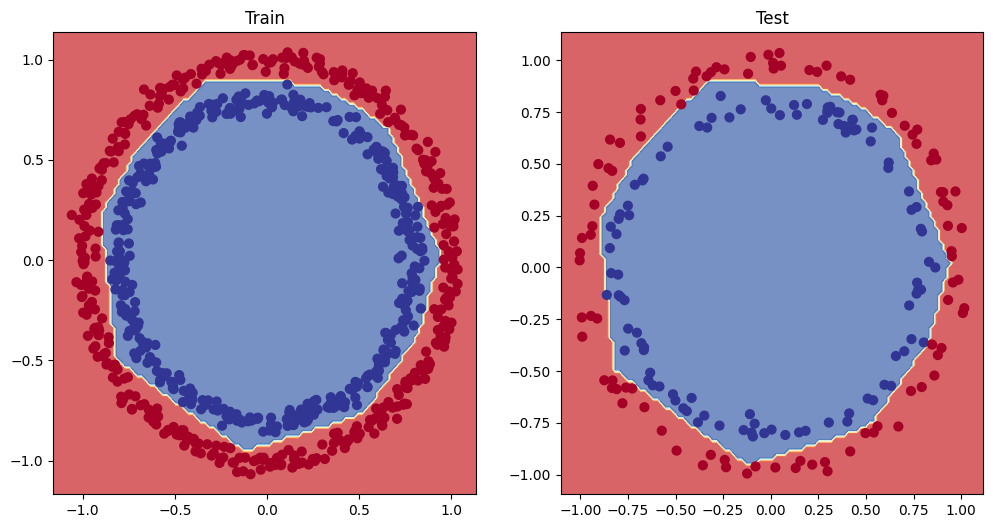

In [167]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

The model has successfully learned the data!